In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%pip install pykalman
%pip install pvlib

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics import r2_score
from pykalman import KalmanFilter
import pvlib


# establish sql connection
db_path = "drive/MyDrive/data/input_data.db"
conn = sqlite3.connect(db_path)
cur = conn.cursor()

# pyplot settings
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams["figure.figsize"] = (16, 8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# # old
# df_forecast = pd.read_excel('data/Forecast_11_to_14.xlsx', usecols=['date', 'pvpower_instant'])
# df_forecast['date'] = pd.to_datetime(df_forecast['date'], format='%Y-%m-%dT%H:%M+00:00')
# df_forecast = df_forecast.loc[(df_forecast['date'].dt.day == 12) | (df_forecast['date'].dt.day == 13)]
# df_real = pd.read_excel('data/PV Generation-data-2022-11-01 12_52_19_neu.xlsx')
# df_real['Timestamp'] = pd.to_datetime(df_real['Timestamp'], format='%d.%m.%Y %H:%M:%S')

# fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=df_real['Timestamp'], y=df_real['Heisenberg/71/260_READ_Power_DC1'], name='Real PV-Power'), secondary_y=True)
# fig.add_trace(go.Scatter(x=df_forecast['date'], y=df_forecast['pvpower_instant'], name='Meteoblue Forecast'), secondary_y=False)
# fig.update_layout(title_text='Vergleich MeteoBlue Forecast vs. Messdaten', title_x=0.5, template='plotly',
#                   xaxis_title='Zeit', xaxis=dict(tickformat='%d.%m %H:%M'),
#                   legend=dict(orientation='h', yanchor="top", y=0.99, xanchor="center", x=0.45))
# fig.update_yaxes(title_text='PV-Messwerte', secondary_y=True)
# fig.update_yaxes(title_text='MeteoBlue Forecast', secondary_y=False)
# fig.show()

Import all data from SQL

In [ ]:

#timerange = "Timestamp between '2022-07-19 00:00:00' and '2022-07-20 00:00:00' ORDER by Timestamp"
baseline=[pd.read_sql_query("SELECT * FROM baseline", conn).set_index('Timestamp'),'baseline']
household_batteries=[pd.read_sql_query("SELECT * FROM household_batteries ", conn).set_index('Timestamp'), 'household_batteries']
mb_basic=[pd.read_sql_query("SELECT * FROM mb_basic ", conn).set_index('Timestamp'),'mb_basic']
mb_pvpro_1h = [pd.read_sql_query("SELECT * FROM mb_pvpro_1h ", conn).set_index('Timestamp'), 'mb_pvpro_1h']
mb_clouds =[ pd.read_sql_query("SELECT * FROM mb_clouds ", conn).set_index('Timestamp'), 'mb_clouds']
mb_solar = [pd.read_sql_query("SELECT * FROM mb_solar ", conn).set_index('Timestamp'), 'mb_solar']
mb_sunmoon = [pd.read_sql_query("SELECT * FROM mb_sunmoon ", conn).set_index('Timestamp'), 'mb_sunmoon']
slp = [pd.read_sql_query("SELECT * FROM slp ", conn).set_index('Timestamp'), 'slp']
mb_pvpro_15min = [pd.read_sql_query("SELECT * FROM mb_pvpro_15min ", conn).set_index('Timestamp'), 'mb_pvpro_15min']
wunderground_historical_40 = [pd.read_sql_query("SELECT * FROM wunderground_historical_40 ", conn).set_index('Date'), 'wunderground_historical_40' ]
wunderground_historical_43 = [pd.read_sql_query("SELECT * FROM wunderground_historical_43 ", conn).set_index('Date'), 'wunderground_historical_43' ]


# baseline.name='baseline'
# household_batteries.name ='household_batteries'
# mb_basic.name = 'mb_basic'
# mb_pvpro_1h.name = 'mb_pvpro_1h'
# mb_clouds.name = 'mb_clouds'
# mb_solar.name = 'mb_solar'
# mb_sunmoon.name = 'mb_sunmoon'
# slp.name = 'slp'
# mb_pvpro_15min.name = 'mb_pvpro_15min'
# wunderground_historical_40.name = 'wunderground_historical_40' 
# wunderground_historical_43.name = 'wunderground_historical_43' 
# wunderground_historical_25.name = 'wunderground_historical_25'

df_list=[baseline, household_batteries, mb_basic, mb_pvpro_1h, mb_clouds, mb_solar, mb_sunmoon, slp, mb_pvpro_15min, wunderground_historical_40, wunderground_historical_43]
for df in df_list:
    df[0].index=pd.to_datetime(df[0].index)
    

print all data

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

for df in df_list:
    tempDf = df[0].loc['2022-10-01 00:00:00': '2022-10-02 00:00:00']     #hier Zeitraum auswählen; aber nicht zu groß, sonst schmiert das hier ab
    for c in tempDf.columns:
        if c in ['Baseline in kW' ]:
            fig.add_trace(go.Scatter(x=tempDf.index, y=tempDf[c], name=df[1]+' '+c), secondary_y=True)
        elif c not in ['rainspot', 'visibility']:  
            fig.add_trace(go.Scatter(x=tempDf.index, y=tempDf[c], name=df[1]+' '+c), secondary_y=False)

fig.show()
#fig.show(renderer='browser')

Interessante Tage:

    Keine/wenig Verschattung:
        '2022-09-21 00:00:00'
        '2022-10-06 00:00:00'
        
    komplette Verschattung:
        '2022-09-24 00:00:00'
        '2022-04-04 00:00:00'

    teilweise bewölkt:
        '2022-10-17 00:00:00'
        '2022-10-16 00:00:00'
        '2022-10-08 00:00:00'

print selected data

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

for df in df_list:
    tempDf = df[0].loc['2022-09-15 00:00:00': '2022-11-14 00:00:00']     #hier Zeitraum auswählen von bis
    for c in tempDf.columns:
        if c in ['Baseline in kW','solar_radiation', 'pvpower_instant']:             #hier Reihe für 1. Achse auswählen
            fig.add_trace(go.Scatter(x=tempDf.index, y=tempDf[c], name=df[1]+' '+c), secondary_y=True)
        elif c in [ 'Pascal', 'Heisenberg', 'Einstein', 'Kelvin', 'Tesla']:                                   #hier Reihe für 2. Achse auswählen
            fig.add_trace(go.Scatter(x=tempDf.index, y=tempDf[c], name=df[1]+' '+c), secondary_y=False)

fig.update_layout(template='plotly')
fig.show(renderer = 'browser')
#pups

PV Vergleich von Max

In [ ]:
df_households = pd.read_sql_query('SELECT Timestamp, Pascal, Einstein, Heisenberg, Kelvin, Tesla FROM household_batteries', conn, parse_dates=['Timestamp'])
df_station40 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_40', conn)
df_station43 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_43', conn)
df_mb_15 = pd.read_sql_query('SELECT Timestamp, pvpower_instant FROM mb_pvpro_15min', conn, parse_dates=['Timestamp'])

df_mb_15 = df_mb_15.resample('1Min', on='Timestamp').mean().ffill()
result_df = df_mb_15.merge(df_households, on='Timestamp', how='inner')

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Scatter(x=result_df['Timestamp'], y=result_df[['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla']]), secondary_y=True)
fig.add_trace(go.Scatter(x=result_df['Timestamp'], y=result_df['pvpower_instant']), secondary_y=False)
fig.show(renderer='browser')

# R2_score
Interpretation:
erklärt Veränderung einer abhängigen Variable

In [ ]:
# read in all PV-related data -> interpolation: 1min timesteps / mean: 15min timesteps
resample_method = 'mean'

df_households = pd.read_sql_query('SELECT Timestamp, Pascal, Einstein, Heisenberg, Kelvin, Tesla FROM household_batteries', conn, parse_dates=['Timestamp'])
df_station40 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_40', conn, parse_dates=['Date'])
df_station40.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_station43 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_43', conn, parse_dates=['Date'])
df_station43.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_mb_15 = pd.read_sql_query('SELECT Timestamp, pvpower_instant FROM mb_pvpro_15min', conn, parse_dates=['Timestamp'])

if resample_method == 'interpolation':
    df_mb_15 = df_mb_15.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station40 = df_station40.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station43 = df_station43.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_results = df_households.merge(df_mb_15, on='Timestamp', how='inner')
elif resample_method == 'mean':
    df_households = df_households.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station40 = df_station40.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station43 = df_station43.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_results = df_mb_15.merge(df_households, on='Timestamp', how='inner')
else:
    print('WRONG RESAMPLE METHOD!!!')
    raise KeyboardInterrupt

df_results = df_results.merge(df_station40, on='Timestamp', how='inner')
df_results = df_results.merge(df_station43, on='Timestamp', how='inner', suffixes=('_40', '_43'))
df_results['sum_households'] = df_results[['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla']].sum(axis=1)
df_results['sum_meteo_error_normalized']=(df_results['pvpower_instant'] / df_results['pvpower_instant'].max()) - (df_results['sum_households'] / df_results['sum_households'].max())
df_results['sum_meteo_error']=df_results['pvpower_instant']-df_results['sum_households']

del df_households, df_station40, df_station43, df_mb_15

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

cols = ['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla', 'sum_households']
for col in cols:
    fig.add_trace(go.Scatter(x=df_results['Timestamp'], y=df_results[col]/df_results[col].max(), name=col+'_normalized', opacity=0.7))
fig.add_trace(go.Scatter(x=df_results['Timestamp'], y=df_results['pvpower_instant'] / df_results['pvpower_instant'].max(), name='MeteoBlue',
                         opacity=0.7))
fig.add_trace(go.Scatter(x=df_results['Timestamp'], y=df_results['solar_radiation_40'] / df_results['solar_radiation_40'].max(),
                         name='Wunderground_40', opacity=0.7))
fig.add_trace(go.Scatter(x=df_results['Timestamp'], y=df_results['solar_radiation_43'] / df_results['solar_radiation_43'].max(),
                         name='Wunderground_43', opacity=0.7))
fig.add_trace(go.Scatter(x=df_results['Timestamp'], y=df_results['sum_meteo_error_normalized'],
                         name='sum_meteo_err_normalized', opacity=0.7)) 
fig.add_trace(go.Scatter(x=df_results['Timestamp'], y=df_results['sum_meteo_error'],
                         name='sum_meteo_err', opacity=0.7), secondary_y=True) 
fig.update_layout(title_text=f'Comparison PV values (resample: {resample_method})', title_x=0.5, template='plotly')
fig.update_yaxes(title_text='Household Batteries', secondary_y=False)
fig.update_yaxes(title_text='MeteoBlue & Wunderground (normalized)', secondary_y=True)
fig.show(renderer='notebook')

In [ ]:
# R2 score
def r2_per_group(data, truth, predicted):
    return r2_score(data[truth], data[predicted])


r2_base = 'pvpower_instant'
fig = make_subplots(specs=[[{'secondary_y': True}]])


cols = ['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla', 'sum_households']
df_r2 = pd.DataFrame(columns=cols)
df_results.dropna(inplace=True)

for col in cols:
    df_r2[col] = df_results.groupby(df_results['Timestamp'].dt.date).apply(r2_per_group, col, r2_base)

#print(df_r2)
fig.add_traces([go.Scatter(x=df_r2.index, y=df_r2[col], name=col, opacity=0.7, mode='lines+markers') for col in cols], secondary_ys=[False] * len(cols))
fig.update_yaxes(title_text='Correlation value', range=[-1, 1], secondary_y=False)

"""
cols_clouds = ['lowclouds', 'midclouds', 'highclouds', 'totalcloudcover']
fig.add_traces([go.Scatter(x=df_corr.index, y=df_corr[col], name=col, opacity=0.7, mode='lines+markers') for col in cols_clouds],
               secondary_ys=[True] * len(cols_clouds))
fig.update_yaxes(title_text='Cloud cover in %', range=[0, 100], secondary_y=True)

fig.update_layout(title_text='Daily Correlation to MeteoBlue Forecast vs. Cloud Cover (mean)', title_x=0.5,
                  xaxis_title='Date', template='plotly')
"""

fig.update_layout(title_text=f'Daily Correlation to MeteoBlue Forecast (resample: {resample_method})', title_x=0.5,
                  xaxis_title='Date', template='plotly')

fig.show(renderer='notebook')

# Correlation

In [ ]:
# read in mb clouds and merge into resampled data

df_mb_clouds = pd.read_sql_query('SELECT * FROM mb_clouds', conn, parse_dates=['Timestamp'])

if resample_method == 'interpolation':
    df_mb_clouds = df_mb_clouds.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
elif resample_method == 'mean':
    df_mb_clouds = df_mb_clouds.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
else:
    print('WRONG RESAMPLE METHOD!!!')
    raise KeyboardInterrupt

df_results = df_results.merge(df_mb_clouds, on='Timestamp', how='inner')

del df_mb_clouds

In [ ]:
# correlate every days measured power

corr_target = 'pvpower_instant'
fig = make_subplots(specs=[[{'secondary_y': True}]])

df_corr = pd.DataFrame()
cols = ['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla', 'sum_households']
for col in cols:
    df_corr = pd.concat([df_corr, df_results.groupby(df_results['Timestamp'].dt.date)[col].corr(df_results[corr_target])], axis=1)

df_corr = pd.concat([df_corr, df_results.groupby(df_results['Timestamp'].dt.date)[['lowclouds', 'midclouds', 'highclouds', 'totalcloudcover']].mean()], axis=1)

fig.add_traces([go.Scatter(x=df_corr.index, y=df_corr[col], name=col, opacity=0.7, mode='lines+markers') for col in cols], secondary_ys=[False] * len(cols))
fig.update_yaxes(title_text='Correlation value', range=[0, 1], secondary_y=False)

"""
cols_clouds = ['lowclouds', 'midclouds', 'highclouds', 'totalcloudcover']
fig.add_traces([go.Scatter(x=df_corr.index, y=df_corr[col], name=col, opacity=0.7, mode='lines+markers') for col in cols_clouds],
               secondary_ys=[True] * len(cols_clouds))
fig.update_yaxes(title_text='Cloud cover in %', range=[0, 100], secondary_y=True)

fig.update_layout(title_text='Daily Correlation to MeteoBlue Forecast vs. Cloud Cover (mean)', title_x=0.5,
                  xaxis_title='Date', template='plotly')
"""

fig.update_layout(title_text=f'Daily Correlation to MeteoBlue Forecast (resample: {resample_method})', title_x=0.5,
                  xaxis_title='Date', template='plotly')

fig.show(renderer='notebook')

# Kalman Filter


In [ ]:
# read in all PV-related data -> interpolation: 1min timesteps / mean: 15min timesteps
resample_method = 'interpolation'

df_households = pd.read_sql_query('SELECT Timestamp, Pascal, Einstein, Heisenberg, Kelvin, Tesla FROM household_batteries', conn, parse_dates=['Timestamp'])
df_station40 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_40', conn, parse_dates=['Date'])
df_station40.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_station43 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_43', conn, parse_dates=['Date'])
df_station43.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_mb_15 = pd.read_sql_query('SELECT Timestamp, pvpower_instant FROM mb_pvpro_15min', conn, parse_dates=['Timestamp'])

if resample_method == 'interpolation':
    df_mb_15 = df_mb_15.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station40 = df_station40.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station43 = df_station43.resample('1Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_results = df_households.merge(df_mb_15, on='Timestamp', how='inner')
elif resample_method == 'mean':
    df_households = df_households.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station40 = df_station40.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_station43 = df_station43.resample('15Min', on='Timestamp').mean().ffill(limit=1).interpolate()
    df_results = df_mb_15.merge(df_households, on='Timestamp', how='inner')
else:
    print('WRONG RESAMPLE METHOD!!!')
    raise KeyboardInterrupt

df_results = df_results.merge(df_station40, on='Timestamp', how='inner')
df_results = df_results.merge(df_station43, on='Timestamp', how='inner', suffixes=('_40', '_43'))
df_results['sum_households'] = df_results[['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla']].sum(axis=1)
df_results['sum_meteo_error_normalized']=(df_results['pvpower_instant'] / df_results['pvpower_instant'].max()) - (df_results['sum_households'] / df_results['sum_households'].max())
df_results['sum_meteo_error']=df_results['pvpower_instant']-df_results['sum_households']

del df_households, df_station40, df_station43, df_mb_15

In [ ]:
from filterpy.kalman import KalmanFilter

f = KalmanFilter (dim_x=2, dim_z=1)
#set initial values
f.x = np.array([0.,    # pv power
                0.])   # change of pv power
#state transition matrix
f.F = np.array([[1.,1.],
                [0.,1.]])
#state transition function
f.H = np.array([[1.,0.]])
#covariance matrix 1000=uncertainty    also possible:    f.P *= 1000.
P=1000.
f.P = np.array([[P,    0.],
                [   0., P] ])
#measurement noise
f.R = 5


df=df_results[['pvpower_instant', 'sum_households', 'Timestamp', 'solar_radiation_43']]

df['sum_normalized']=df_results['sum_households']/df_results['sum_households'].max()
df['meteo_normalized']=df_results['pvpower_instant'] / df_results['pvpower_instant'].max()
df['error']=df['meteo_normalized']-df['sum_normalized']
i=0
for idx, row in df.iterrows():
    
    z = row['sum_normalized']
    # print(z)
    df.loc[idx,'kalman']=f.x[0]
    f.predict()
    f.update(z)
    
    #print(f.x)
    i+=1
    print(f.x[0])
    # if i==5:
    #     break
print(df[['kalman', 'pvpower_instant', 'sum_households']])
df['kalmanError']=df['kalman']-df['sum_normalized']
df.set_index('Timestamp', inplace=True)

In [ ]:

fig = make_subplots(specs=[[{'secondary_y': True}]])

cols = ['sum_normalized', 'meteo_normalized', 'error', 'kalman', 'kalmanError']
for col in cols:
    fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col, opacity=0.7))

fig.add_trace(go.Scatter(x=df.index, y=df['sum_normalized'],
                         name='sum_meteo_err', opacity=0.7), secondary_y=False) 
fig.add_trace(go.Scatter(x=df.index, y=df['solar_radiation_43']/df['solar_radiation_43'].max(),
                         name='solar_radiation_43', opacity=0.7), secondary_y=False)                     

fig.show(renderer='notebook')


# Vergleich Wonderground43 und household_batteries

import data

In [6]:
# read in all PV-related data -> interpolation: 1min timesteps / mean: 15min timesteps
resample_interval = '1Min'

df_households = pd.read_sql_query('SELECT Timestamp, Pascal, Einstein, Heisenberg, Kelvin, Tesla FROM household_batteries', conn, parse_dates=['Timestamp'])
df_station43 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_43_long_real', conn, parse_dates=['Date'])
df_station43.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_station40 = pd.read_sql_query('SELECT Date, solar_radiation, tempAvg, windspeedAvg FROM wunderground_historical_40', conn, parse_dates=['Date'])
df_station40.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_mb_15 = pd.read_sql_query('SELECT Timestamp, pvpower_instant FROM mb_pvpro_15min', conn, parse_dates=['Timestamp'])

df_results=pd.merge(left=df_households, right=df_station40, how='outer',on='Timestamp')
df_results = pd.merge(left=df_results, right=df_station43, how='outer', suffixes=('_40', '_43'),on='Timestamp')
# df_results=pd.merge(left=df_results, right=df_station40, how='outer',on='Timestamp')
df_results=pd.merge(left=df_results, right=df_mb_15, how='outer',on='Timestamp')
# df_results=addTimeDelta(df_results)
# df_results=addMissingValsColumn(df_results)

df_results = df_results.resample(resample_interval, on='Timestamp').mean().ffill(limit=1).interpolate()
# df_results.dropna(inplace=True)
# df_results['measuredBool']=df_results.loc(df_results['missingValsBelow']==0).shift(period=1)

df_results['sum_households'] = df_results[['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla']].sum(axis=1)
df_results=pd.concat([df_results.loc['2022-09-16 00:00:00':'2022-10-18 00:00:00'],df_results.loc['2022-10-26 00:00:00':'2022-11-15 00:00:00']])

del df_households, df_station40, df_station43

Text(0.5, 1.0, 'Data Comparison (29.10.2022)')

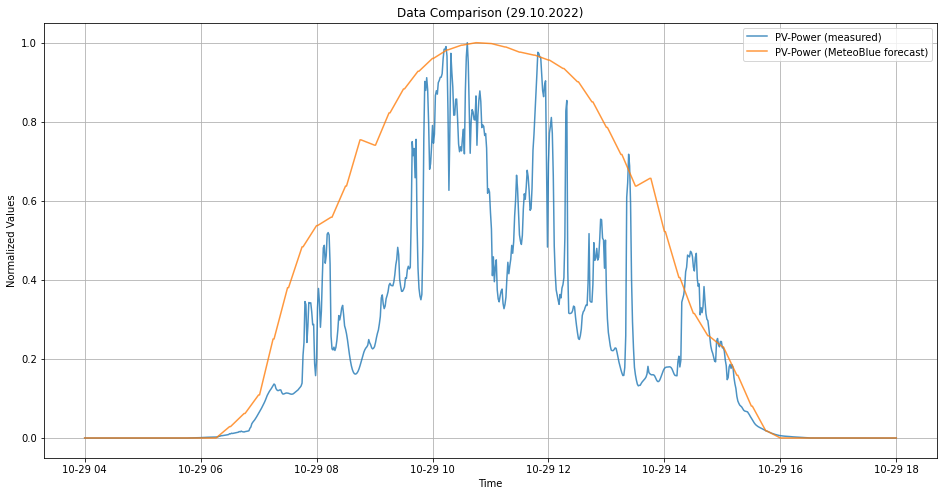

In [32]:
filtered = df_results.loc['2022-10-29 04:00:00':'2022-10-29 18:00:00']

"""
fig.add_trace(go.Scatter(x=filtered.index, y=filtered['solar_radiation_40']/filtered['solar_radiation_40'].max(), name='Wonderground 40', opacity=0.7))
fig.add_trace(go.Scatter(x=filtered.index, y=filtered['solar_radiation_43']/filtered['solar_radiation_43'].max(), name='Wonderground 43', opacity=0.7))
fig.add_trace(go.Scatter(x=filtered.index, y=filtered['sum_households']/filtered['sum_households'].max(), name='PV-Power (measured)', opacity=0.7))
fig.add_trace(go.Scatter(x=filtered.index, y=filtered['pvpower_instant']/filtered['pvpower_instant'].max(), name='PV-Power (MeteoBlue forecast)', opacity=0.7))

fig.update_layout(title_text='Data Comparison (29.10.2022)', title_x=0.5, yaxis_title='Normalized Values')
fig.show()
"""

# plt.plot(filtered.index, filtered['solar_radiation_40']/filtered['solar_radiation_40'].max(), label='Wonderground 40', alpha=0.8)
# plt.plot(filtered.index, filtered['solar_radiation_43']/filtered['solar_radiation_43'].max(), label='Wonderground 43', alpha=0.8)
plt.plot(filtered.index, filtered['sum_households']/filtered['sum_households'].max(), label='PV-Power (measured)', alpha=0.8)
plt.plot(filtered.index, filtered['pvpower_instant']/filtered['pvpower_instant'].max(), label='PV-Power (MeteoBlue forecast)', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Normalized Values')
# axes[0].set_xlim(0, 1)
# axes[0].set_ylim(bottom=0)
plt.legend()
plt.grid()
plt.title('Data Comparison (29.10.2022)')



In [ ]:

fig = make_subplots(specs=[[{'secondary_y': True}]])

df=df_results[df_results.index.hour > 10]
# df=df_results
fig = px.scatter(x=df['solar_radiation_40'], y=df['sum_households'])
# fig.add_trace(go.Scatter(x=df_results['solar_radiation'], y=df_results['sum_households'],
#                          name='sum_meteo_err'), secondary_y=False)                  

fig.show(renderer='notebook')

In [ ]:

fig = make_subplots(specs=[[{'secondary_y': True}]])


fig = px.scatter(x=df_results['pvpower_instant'], y=df_results['sum_households'])
# fig.add_trace(go.Scatter(x=df_results['solar_radiation'], y=df_results['sum_households'],
#                          name='sum_meteo_err'), secondary_y=False)                  

fig.show(renderer='notebook')

correlation

In [ ]:

df_results[df_results.index.hour > 12].drop(columns=['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla']).corr()

#radiation to power

Anlage / kwp / Ausrichtung / Lage
- Einstein 8.76 kwp / 235° / lat:52.825,lon:8.632
- Pascal 6.65 kwp / 140° / lat:52.826,lon:8.634
- Tesla 4.14 kwp / 183° / lat:52.826,lon:8.634
- Kelvin 7.77 kwp / 100° / lat:52.826,lon:8.634
- Heisenberg 6.94 kwp / 190° / lat:52.825,lon:8.632
"height":50 m ü NN


In [134]:
# read in all PV-related data -> interpolation: 1min timesteps / mean: 15min timesteps
resample_interval = '15Min'

df_households = pd.read_sql_query('SELECT Timestamp, Pascal, Einstein, Heisenberg, Kelvin, Tesla FROM household_batteries', 
                                  conn, parse_dates=['Timestamp'], index_col='Timestamp')
df_households = df_households.resample(resample_interval).mean().ffill(limit=1).interpolate()

df_station43 = pd.read_sql_query('SELECT Date, solar_radiation FROM wunderground_historical_43_long_real', 
                                 conn, parse_dates=['Date'], index_col='Date')
df_station43.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_station43 = df_station43.resample(resample_interval).mean().ffill(limit=1).interpolate()

df_station40 = pd.read_sql_query('SELECT Date, solar_radiation, tempAvg, windspeedAvg FROM wunderground_historical_40', 
                                 conn, parse_dates=['Date'], index_col='Date')
df_station40.rename(columns={'Date': 'Timestamp'}, inplace=True)
df_station40 = df_station40.resample(resample_interval).mean().ffill(limit=1).interpolate()

df_mb_15 = pd.read_sql_query('SELECT Timestamp, pvpower_instant FROM mb_pvpro_15min', 
                             conn, parse_dates=['Timestamp'], index_col='Timestamp')
df_mb_15 = df_mb_15.resample(resample_interval).mean().ffill(limit=1).interpolate()

df_mb_clouds = pd.read_sql_query('SELECT Timestamp, totalcloudcover FROM mb_clouds', 
                                 conn, parse_dates=['Timestamp'], index_col='Timestamp')
df_mb_clouds = df_mb_clouds.resample(resample_interval).mean().ffill(limit=1).interpolate()

df_results=pd.merge(left=df_households, right=df_station40, how='inner', left_index=True, right_index=True)
df_results=pd.merge(left=df_results, right=df_station43, how='inner', suffixes=('_40', '_43'), left_index=True, right_index=True)
df_results=pd.merge(left=df_results, right=df_mb_15, how='inner', left_index=True, right_index=True)
# df_results=pd.merge(left=df_results, right=df_mb_clouds, how='inner', left_index=True, right_index=True)
df_results['Date'] = df_results.index

# df_results=addTimeDelta(df_results)
# df_results=addMissingValsColumn(df_results)

# df_results = df_results.resample(resample_interval).mean().ffill(limit=1).interpolate()
# df_results.dropna(inplace=True)
# df_results['measuredBool']=df_results.loc(df_results['missingValsBelow']==0).shift(period=1)

df_results['sum_households'] = df_results[['Pascal', 'Einstein', 'Heisenberg', 'Kelvin', 'Tesla']].sum(axis=1)
df_results=pd.concat([df_results.loc[:'2022-10-18 00:00:00'],df_results.loc['2022-10-26 00:00:00':]])

# wrong_dates = [pd.Timestamp(day=22, month=9, year=2022), pd.Timestamp(day=4, month=10, year=2022), pd.Timestamp(day=5, month=10, year=2022)]
# df_results = df_results.loc[~df_results['Date'].dt.date.isin(wrong_dates)]
df_results = df_results.loc[df_results['Date'].dt.date != pd.Timestamp(day=4, month=10, year=2022)]
df_results = df_results.loc[df_results['Date'].dt.date != pd.Timestamp(day=5, month=10, year=2022)]
df_results = df_results.loc[df_results['Date'].dt.date != pd.Timestamp(day=22, month=9, year=2022)]

# del df_households, df_station40

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [135]:
specs={
    'Einstein':{
        'kWp':8.76,
        'Neigung':45,
        'Azimuth':235,
        'lat':52.825,
        'lon':8.632
    },
    'Pascal':{
        'kWp':6.65,
        'Neigung':45,
        'Azimuth':140,
        'lat':52.826,
        'lon':8.634
    },
    'Tesla':{
        'kWp':4.14,
        'Neigung':45,
        'Azimuth':183,
        'lat':52.826,
        'lon':8.634
    },
    'Kelvin':{
        'kWp':7.77,
        'Neigung':45,
        'Azimuth':100,
        'lat':52.826,
        'lon':8.634
    },
    'Heisenberg':{
        'kWp':6.94,
        'Neigung':45,
        'Azimuth':190,
        'lat':52.825,
        'lon':8.632
    }
}

In [136]:
location = pvlib.location.Location(latitude=specs['Heisenberg']['lat'],
                                   longitude=specs['Heisenberg']['lon'])

# times = df_results.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(df_results.index)
# solar_position.index += pd.Timedelta('30min')

# df_poa = pvlib.irradiance.gti_dirint() # gets gni, dhi, dni from global
poa = df_results['solar_radiation_40']

In [137]:
parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['insulated_back_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(poa,
                                               df_results['tempAvg'],
                                               df_results['windspeedAvg'],
                                               **parameters)

Text(0, 0.5, 'Temperature [°C]')

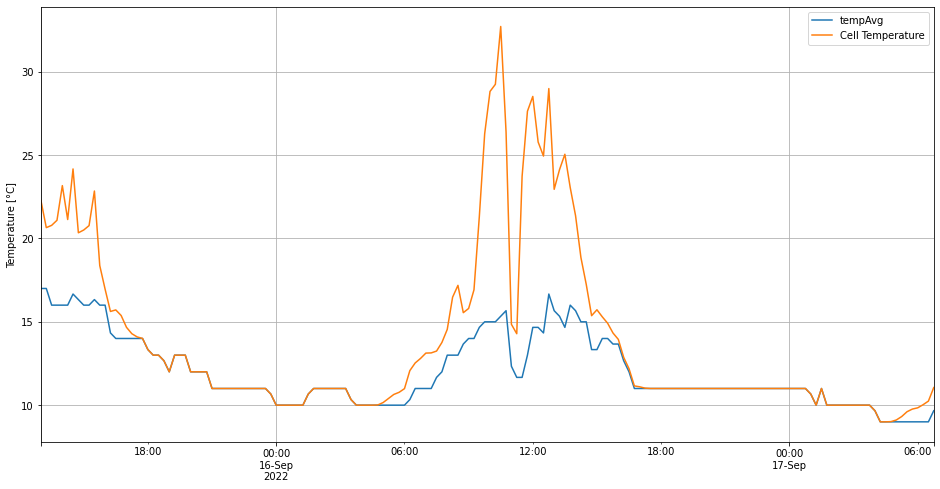

In [138]:

df_results['tempAvg'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['tempAvg', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]')

In [139]:
split_hour = 10
tilts = range(-180, 180, 5)
df_results['sum_households_plane']=0
df_test_tilt = pd.DataFrame()
for s in specs:
    corr = 0
    corr_list = []
    for tilt in tilts:
        # tilt = specs[s]['Neigung']
        azimuth = specs[s]['Azimuth']
        # calc dhi and dni from ghi
        erbs = pvlib.irradiance.erbs(poa, solar_position.zenith, poa.index, min_cos_zenith=0.065, max_zenith=87)
        #calc poa on plane
        POA_irradiance = pvlib.irradiance.get_total_irradiance(
            surface_tilt=tilt,
            surface_azimuth=azimuth,
            dni=erbs.dni,
            ghi=poa,
            dhi=erbs.dhi,
            solar_zenith=solar_position['zenith'],
            solar_azimuth=solar_position['azimuth'])

        gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
        nameplate = specs[s]['kWp']
        array_power = pvlib.pvsystem.pvwatts_dc(POA_irradiance['poa_global'], cell_temperature, nameplate, gamma_pdc)
        temp_corr = df_results[s][df_results.index.hour > split_hour].corr(array_power[array_power.index.hour > split_hour])
        corr_list.append(temp_corr)
        if temp_corr > corr:
            corr = temp_corr
            print(f'{s} ({tilt}):\t{corr}')
            df_results[s+'_plane'] = array_power
    
    df_test_tilt = pd.concat([df_test_tilt, pd.DataFrame({s: corr_list})], axis=1)
    df_results['sum_households_plane'] += df_results[s+'_plane']

df_test_tilt.index = list(tilts)
df_test_tilt['Mean'] = df_test_tilt.sum(axis=1)/len(df_test_tilt.columns)

Einstein (-180):	0.9161365850282913
Einstein (-175):	0.916472317093606
Einstein (-170):	0.9174471833839106
Einstein (-165):	0.9189692273989934
Einstein (-160):	0.9209008041325489
Einstein (-155):	0.9230782975864873
Einstein (-150):	0.9253334704558184
Einstein (-145):	0.9275124508061281
Einstein (-140):	0.9294895001870453
Einstein (-135):	0.9311743420291928
Einstein (-130):	0.9325133906544368
Einstein (-125):	0.9334862950660164
Einstein (-120):	0.9340996507550243
Einstein (-115):	0.9343796304582447
Pascal (-180):	0.9387487716149454
Pascal (-175):	0.9389735585528242
Pascal (-170):	0.9396191828346545
Pascal (-165):	0.9406049777831476
Pascal (-160):	0.9418128805709616
Pascal (-155):	0.9431057208198768
Pascal (-150):	0.9443452060308384
Pascal (-145):	0.9454089097093843
Pascal (-140):	0.9462060856731856
Pascal (-135):	0.9466661321456753
Pascal (-130):	0.9467413704541039
Tesla (-180):	0.8996324340396065
Tesla (-175):	0.8998848863356679
Tesla (-170):	0.9006137834756595
Tesla (-165):	0.90173839

Text(0.5, 1.0, 'Correlation vs. Model Tilt')

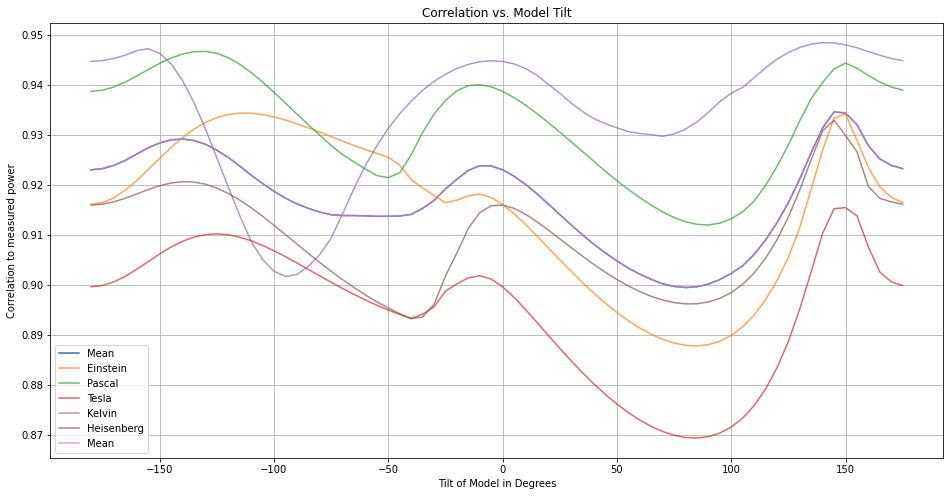

In [140]:
fig, ax = plt.subplots()
ax.plot(df_test_tilt.index, df_test_tilt['Mean'], label='Mean', alpha=1)
# max_val = df_test_tilt['Mean'].loc[df_test_tilt['Mean'] == df_test_tilt['Mean'].max()]
# ax.add_patch(plt.Circle(tuple([max_val.index[0], max_val.iloc[0]]), 1))

for col in df_test_tilt.columns:
    ax.plot(df_test_tilt.index, df_test_tilt[col], label=col, alpha=0.7)
    # max_val = df_test_tilt[col].loc[df_test_tilt[col] == df_test_tilt[col].max()]
    # ax.add_patch(plt.Circle(tuple([max_val.index[0], max_val.iloc[0]]), 1))

plt.xlabel('Tilt of Model in Degrees')
plt.ylabel('Correlation to measured power')
plt.legend()
plt.grid()
plt.title('Correlation vs. Model Tilt')

In [147]:
best_tilt = df_test_tilt['Mean'].loc[df_test_tilt['Mean'] == df_test_tilt['Mean'].max()].index[0]

In [148]:
df_results['sum_households_plane_uniform'] = 0
for s in specs:
    azimuth = specs[s]['Azimuth']
    # calc dhi and dni from ghi
    erbs = pvlib.irradiance.erbs(poa, solar_position.zenith, poa.index, min_cos_zenith=0.065, max_zenith=87)
    #calc poa on plane
    POA_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt=best_tilt,
        surface_azimuth=azimuth,
        dni=erbs.dni,
        ghi=poa,
        dhi=erbs.dhi,
        solar_zenith=solar_position['zenith'],
        solar_azimuth=solar_position['azimuth'])

    gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
    nameplate = specs[s]['kWp']
    array_power = pvlib.pvsystem.pvwatts_dc(POA_irradiance['poa_global'], cell_temperature, nameplate, gamma_pdc)
    df_results[s+'_plane_uniform'] = array_power

    df_test_tilt = pd.concat([df_test_tilt, pd.DataFrame({s: corr_list})], axis=1)
    df_results['sum_households_plane_uniform'] += df_results[s+'_plane_uniform']

In [149]:
before = df_results.loc[df_results['Date'].dt.hour <= split_hour]
after = df_results.loc[df_results['Date'].dt.hour > split_hour]

In [150]:
# alle zeitpunkte
df_results[['sum_households', 'pvpower_instant', 'solar_radiation_43', 'solar_radiation_40', 'sum_households_plane', 'sum_households_plane_uniform']].corr()

,sum_households,pvpower_instant,solar_radiation_43,solar_radiation_40,sum_households_plane,sum_households_plane_uniform
sum_households,1.000000,0.923226,0.901786,0.860239,0.883485,0.874277
pvpower_instant,0.923226,1.000000,0.858553,0.814364,0.858564,0.840475
solar_radiation_43,0.901786,0.858553,1.000000,0.903330,0.900824,0.881965
solar_radiation_40,0.860239,0.814364,0.903330,1.000000,0.986747,0.986231
sum_households_plane,0.883485,0.858564,0.900824,0.986747,1.000000,0.996213
sum_households_plane_uniform,0.874277,0.840475,0.881965,0.986231,0.996213,1.000000


In [151]:
# bis split
before[['sum_households', 'pvpower_instant', 'solar_radiation_43', 'solar_radiation_40', 'sum_households_plane', 'sum_households_plane_uniform']].corr()

,sum_households,pvpower_instant,solar_radiation_43,solar_radiation_40,sum_households_plane,sum_households_plane_uniform
sum_households,1.000000,0.929220,0.905317,0.797634,0.824784,0.813616
pvpower_instant,0.929220,1.000000,0.877755,0.785651,0.825593,0.810172
solar_radiation_43,0.905317,0.877755,1.000000,0.866911,0.875805,0.859151
solar_radiation_40,0.797634,0.785651,0.866911,1.000000,0.989612,0.990120
sum_households_plane,0.824784,0.825593,0.875805,0.989612,1.000000,0.997642
sum_households_plane_uniform,0.813616,0.810172,0.859151,0.990120,0.997642,1.000000


In [152]:
# ab split
after[['sum_households', 'pvpower_instant', 'solar_radiation_43', 'solar_radiation_40', 'sum_households_plane', 'sum_households_plane_uniform']].corr()

,sum_households,pvpower_instant,solar_radiation_43,solar_radiation_40,sum_households_plane,sum_households_plane_uniform
sum_households,1.000000,0.917393,0.898558,0.943354,0.958980,0.956389
pvpower_instant,0.917393,1.000000,0.840631,0.877182,0.919003,0.904996
solar_radiation_43,0.898558,0.840631,1.000000,0.964814,0.948386,0.933829
solar_radiation_40,0.943354,0.877182,0.964814,1.000000,0.985945,0.984560
sum_households_plane,0.958980,0.919003,0.948386,0.985945,1.000000,0.995977
sum_households_plane_uniform,0.956389,0.904996,0.933829,0.984560,0.995977,1.000000


In [84]:
from sklearn.metrics import mean_squared_error
results = pd.DataFrame()
for i in range(24):
    filtered = df_results.loc[df_results['Date'].dt.hour == i]
    
    wg40 = filtered['sum_households'].corr(filtered['solar_radiation_40'])    
    wg43 = filtered['sum_households'].corr(filtered['solar_radiation_43'])    
    mb = filtered['sum_households'].corr(filtered['pvpower_instant'])
    plane = filtered['sum_households'].corr(filtered['sum_households_plane'])
    plane_uniform = filtered['sum_households'].corr(filtered['sum_households_plane_uniform'])
    """
    wg40 = mean_squared_error(filtered['sum_households'], filtered['solar_radiation_40'])
    wg43 = mean_squared_error(filtered['sum_households'], filtered['solar_radiation_43'])
    mb = mean_squared_error(filtered['sum_households'], filtered['pvpower_instant'])
    """
    results = pd.concat([results, pd.DataFrame({'MeteoBlue': [mb], 'Wg43': [wg43], 'Wg40': [wg40], 'Wg40 Power': [plane], 
                                                'Wg40 Power (uniform tilt)': [plane_uniform]}, index=[i])])

Text(0.5, 1.0, 'Correlation to Households depending on time of day')

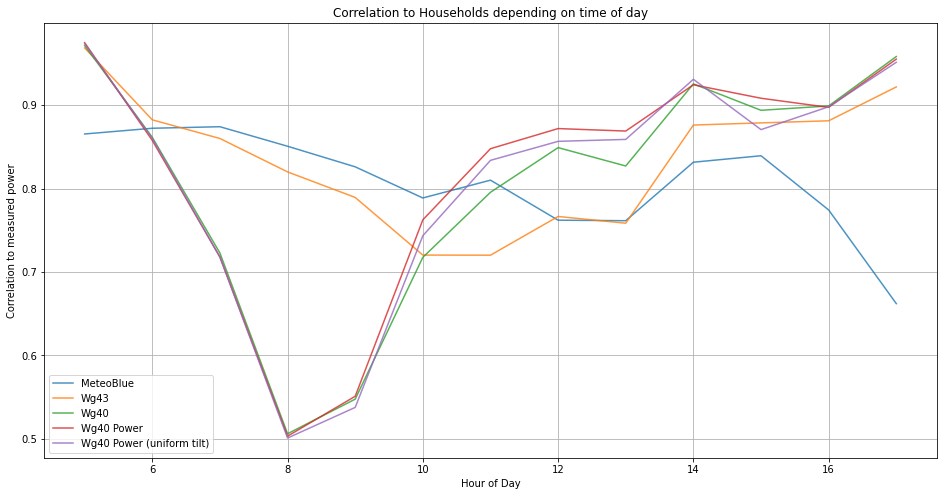

In [93]:
"""
fig = px.line(results[5:17], y=results.columns, log_y=False)
fig.update_layout(title='Correlation to Households depending on time of day', title_x=0.5,
                  xaxis_title='Hour of Day', yaxis_title='Correlation')
fig.show()
"""
filtered = results.iloc[5:18]
for col in filtered.columns:
    plt.plot(filtered.index, filtered[col], label=col, alpha=0.8)

plt.xlabel('Hour of Day')
plt.ylabel('Correlation to measured power')
plt.legend()
plt.grid()
plt.title('Correlation to Households depending on time of day')

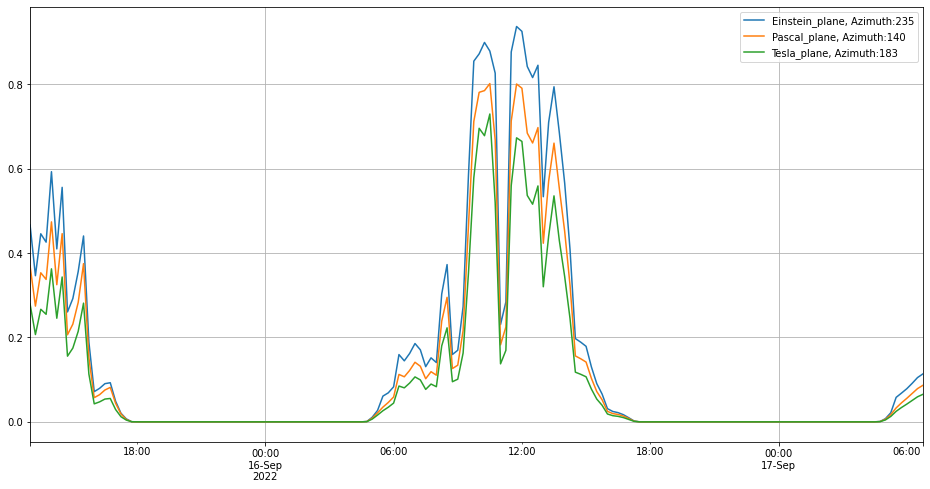

In [ ]:
(df_results['Einstein_plane']/df_results['Einstein_plane'].max()).head(24*7).plot()
(df_results['Pascal_plane']/df_results['Pascal_plane'].max()).head(24*7).plot()
(df_results['Tesla_plane']/df_results['Tesla_plane'].max()).head(24*7).plot()
plt.grid()
plt.legend(['Einstein_plane, Azimuth:'+str(specs['Einstein']['Azimuth']), 'Pascal_plane, Azimuth:'+str(specs['Pascal']['Azimuth']), 'Tesla_plane, Azimuth:'+str(specs['Tesla']['Azimuth'])])


In [ ]:
to_plot = 'after'

if to_plot == 'after':
    fig = px.scatter(after, x='solar_radiation_40', y='sum_households', opacity=0.7, hover_name='Date', template='plotly', trendline='ols')
    fig.update_layout(title=f'Wunderground 40 vs. Households (> {split_hour}am)', title_x=0.5, xaxis_title='Solar radiation', yaxis_title='PV-Power')
elif to_plot == 'before':
    fig = px.scatter(before, x='solar_radiation_40', y='sum_households', opacity=0.7, hover_name='Date', template='plotly', trendline='ols')
    fig.update_layout(title=f'Wunderground 40 vs. Households (<= {split_hour}am)', title_x=0.5, xaxis_title='Solar radiation', yaxis_title='PV-Power')
else:
    print('Wrong "to_plot"!!!')

fig.show()

In [ ]:
to_plot = 'after'

if to_plot == 'after':
    fig = px.scatter(after, x='sum_households_plane', y='sum_households', opacity=0.7, hover_name='Date', template='plotly', trendline='ols')
    fig.update_layout(title=f'Wunderground 40 (Power) vs. Households (> {split_hour}am)', title_x=0.5, xaxis_title='PV-Power from WG40', yaxis_title='PV-Power')
elif to_plot == 'before':
    fig = px.scatter(before, x='sum_households_plane', y='sum_households', opacity=0.7, hover_name='Date', template='plotly', trendline='ols')
    fig.update_layout(title=f'Wunderground 40 (Power) vs. Households (<= {split_hour}am)', title_x=0.5, xaxis_title='PV-Power from WG40', yaxis_title='PV-Power')
else:
    print('Wrong "to_plot"!!!')

fig.show()

In [ ]:
to_plot = 'after'

if to_plot == 'after':
    fig = px.scatter(after, x='solar_radiation_40', y='sum_households_plane', opacity=0.7, hover_name='Date', template='plotly')
    fig.update_layout(title=f'Wg40 radiation vs. Wg40 Power (> {split_hour}am)', title_x=0.5, 
                      xaxis_title='Solar radiation', yaxis_title='PV-Power from WG40')
elif to_plot == 'before':
    fig = px.scatter(before, x='solar_radiation_40', y='sum_households_plane', opacity=0.7, hover_name='Date', template='plotly')
    fig.update_layout(title=f'Wg40 radiation vs. Wg40 Power (<= {split_hour}am)', title_x=0.5, 
                      xaxis_title='Solar radiation', yaxis_title='PV-Power from WG40')
else:
    print('Wrong "to_plot"!!!')

fig.show()

In [ ]:
# assumptions from the technical report:
# tilt = specs['Heisenberg']['Neigung']
# azimuth = specs['Heisenberg']['Azimuth']

# aoi = pvlib.irradiance.aoi(tilt, azimuth, solar_position.apparent_zenith, solar_position.azimuth)
# erbs = pvlib.irradiance.erbs(poa, solar_position.apparent_zenith, poa.index, min_cos_zenith=0.065, max_zenith=87)
# # disc = pvlib.irradiance.disc(poa, solar_position.apparent_zenith, poa.index, pressure=101325, min_cos_zenith=0.065, max_zenith=87, max_airmass=12)
# # dirint=pvlib.irradiance.dirint(poa, solar_position.apparent_zenith, poa.index, pressure=101325.0, use_delta_kt_prime=True, temp_dew=None, min_cos_zenith=0.065, max_zenith=87)
# # dirint.fillna(0, inplace=True)

# POA_irradiance = pvlib.irradiance.get_total_irradiance(
#        surface_tilt=tilt,
#        surface_azimuth=azimuth,
#        dni=erbs.dhi,
#        ghi=poa,
#        dhi=erbs.dhi,
#        solar_zenith=solar_position['apparent_zenith'],
#        solar_azimuth=solar_position['azimuth'])



In [ ]:
# gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
# nameplate = specs['Heisenberg']['kWp']

# array_power = pvlib.pvsystem.pvwatts_dc(POA_irradiance['poa_global'], cell_temperature, nameplate, gamma_pdc)
# array_power_horizontal = pvlib.pvsystem.pvwatts_dc(poa, cell_temperature, nameplate, gamma_pdc)

Text(0, 0.5, 'Array Power [kW]')

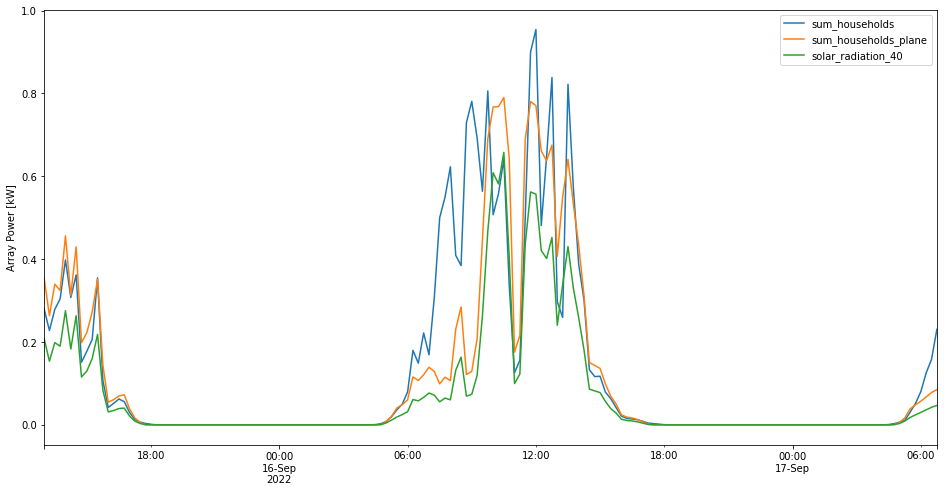

In [ ]:
(df_results['sum_households']/df_results['sum_households'].max()).head(24*7).plot()
(df_results['sum_households_plane']/df_results['sum_households_plane'].max()).head(24*7).plot()
(df_results['solar_radiation_40']/df_results['solar_radiation_40'].max()).head(24*7).plot()
plt.legend(['sum_households', 'sum_households_plane','solar_radiation_40'])
plt.ylabel('Array Power [kW]')

In [ ]:
df_results[df_results.index.hour > 12].corr()